# FAST-UAV - Multirotor Design Optimization

[FAST-OAD](https://fast-oad.readthedocs.io) is a framework for performing rapid Overall Aircraft Design. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/). <br>
FAST-UAV is the drone declination of FAST-OAD.

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [DJI Matrice 600 Pro](https://www.dji.com/matrice600-pro) multicopter. In `workdir/`, we store files generated or modified by FAST-UAV.

In [1]:
import os.path as pth
import openmdao.api as om
import logging
import shutil
import fastoad.api as oad
from fastuav.cmd.lca import *
from time import time
from IPython.display import IFrame
import matplotlib.pyplot as plt
import brightway2 as bw
from fastuav.utils.postprocessing.analysis_and_plots import *
from fastuav.utils.postprocessing.lca import *

plt.rcParams["figure.figsize"] = 16, 8
plt.rcParams.update({"font.size": 13})

DATA_FOLDER_PATH = "../data"
CONFIGURATIONS_FOLDER_PATH = "../configurations"
WORK_FOLDER_PATH = "./workdir"

CONFIGURATION_FILE = pth.join(WORK_FOLDER_PATH, "multirotor_mdo_lca.yaml")
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_inputs_lca.xml")

CONFIGURATION_FILE_LCA_ONLY = pth.join(WORK_FOLDER_PATH, "multirotor_lca.yaml")
ECOINVENT_PATH = r"D:/THESE/LCA_databases/ecoinvent 3.9_cutoff_ecoSpold02/datasets"   # path to the datasets subfolder; mind that the ecoinvent file must be unzipped.

# For having log messages display on screen
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")

# For using all screen width
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\f.pollet.ISAE-SUPAERO\AppData\Local\Temp\ipykernel_12396\3399439061.py:31: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_mdo_lca.yaml"
)

INFO    : Loading FAST-OAD plugin uav
INFO    : Loading bundles from fastuav.models
INFO    : Installed bundle fastuav.models.geometry.__init__ (ID 19 )
INFO    : Installed bundle fastuav.models.performance.__init__ (ID 40 )
INFO    : Installed bundle fastuav.models.propulsion.energy.battery.performance_analysis (ID 46 )
INFO    : Installed bundle fastuav.models.propulsion.motor.estimation_models (ID 61 )
INFO    : Installed bundle fastuav.models.structures.structures_fixedwing_obsolete (ID 105 )
INFO    : Installed bundle fastuav.models.life_cycle_assessment.lca (ID 20 )
INFO    : Installed bundle fastuav.models.performance.mission.route_builder (ID 37 )
INFO    : Installed bundle fastuav.models.stability.static_longitudinal.neutral_point (ID 99 )
INFO    : Installed bundle fastuav.models.performance.mission.__init__ (ID 38 )
INFO    : Installed bundle fastuav.models.structures.structures_hybrid (ID 106 )
INFO    : Installed bundle fastuav.models.life_cycle_assessment.lca_core (ID 21 

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\multirotor_mdo_lca.yaml'

------------------------------
### LCA project setup

The LCA module of FAST-UAV requires the **EcoInvent 3.9** database. You must first download it [here](https://v39.ecoquery.ecoinvent.org/Home/Index), then unzip it in the folder specified by the ECOINVENT_PATH variable.

When it's done, the following line will create a Brightway project for you and import the database. This process takes a few minutes.

Once the project is created and the database imported, you won't have to reinstall it the next times you use this notebook.

In [3]:
create_lca_project(project_name="fastuav", db_path=ECOINVENT_PATH, db_name="ecoinvent 3.9_cutoff_ecoSpold02")

Biosphere database already present!!! No setup is needed
"ecoinvent 3.9_cutoff_ecoSpold02" database already present!!! No setup is needed
Available projects on your computer: 
 [Project: default, Project: StepByStep, Project: BW2 introduction, Project: bw2_seminar_2017, Project: bw2_uav, Project: bw2_uav_2, Project: fastuav, Project: fastua2v, Project: bw2_export, Project: certificat_2023, Project: certificat, Project: silicon_battery, Project: MyProject, Project: test]
Available databases in project "fastuav": 
 ['biosphere3', 'ecoinvent 3.9_cutoff_ecoSpold02', 'Foreground DB']


---------------
The YAML configuration file located in the data folder defines the design problem, i.e. the model, the problem driver and the optimization problem definition.<br>
A useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [4]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
IFrame(src=N2_FILE, width="100%", height="500px")

INFO    : N2 diagram written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\n2.html


In [5]:
#oad.generate_configuration_file(
#    CONFIGURATION_FILE_LCA_ONLY, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_lca.yaml"
#)
LCA_FILE = pth.join(WORK_FOLDER_PATH, "LCA_processes.html")
net = graph_activities(CONFIGURATION_FILE)
net.show(LCA_FILE)

Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it


In the configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-UAV to generate the inputs of the model with the reference parameters from 'problem_inputs_DJI_M600.xml' as default values:

In [6]:
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
INFO    : Problem inputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_inputs.xml


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

You can now checkout the generated [input file](./workdir/problem_inputs.xml). The values in this file can be modified by the user and will be considered by FAST-UAV when executing a computational process.<br>
The `variable-viewer` provides a way to inspect and modify the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [7]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

## 2. Running an MDO

You can now run an optimization problem. The last part of the configuration file .yaml is where this optimization problem is defined:

```yaml
optimization:
  design_variables:
    - name: data:weights:mtow:k # over estimation coefficient on the load mass
      upper: 40.0
      lower: 1.0
  constraints:
    - name: data:weights:mtow:guess:constraint # mass consistency
      lower: 0.0
  objective:
    - name: data:weights:mtow
      scaler: 1e-1
```

In [8]:
eval_problem = oad.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
INFO    : Created LCA object
INFO    : {'message': 'Started MultiLCA calculation', 'methods': [('EF v3.1', 'acidification', 'accumulated exceedance (AE)'), ('EF v3.1', 'climate change', 'global warming potential (GWP100)'), ('EF v3.1', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)'), ('EF v3.1', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels'), ('EF v3.1', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)'), ('EF v3.1', 'eutrophication: marine', 'fraction of nutrients reaching marine end compartment (N)'), ('EF v3.1', 'eutrophication: terrestrial', 'accumulated exceedance (A

In [9]:
optim_problem = oad.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5621522231354513
            Iterations: 15
            Function evaluations: 25
            Gradient evaluations: 15
Optimization Complete
-----------------------------------


INFO    : Computation finished after 38.98 seconds
INFO    : Problem outputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_outputs.xml


Let's save these results:

In [10]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
MDO_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, 'problem_outputs_lca_mdo.xml')
shutil.copy(OUTPUT_FILE, MDO_OUTPUT_FILE)

'../data\\problem_outputs_lca_mdo.xml'

The `optimizer_viewer` offers a convenient summary of the optimization result. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated.

In [11]:
oad.optimization_viewer(CONFIGURATION_FILE)

D:\Softwares\Miniconda3\envs\FAST-UAV\lib\site-packages\jupyter_client\session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [12]:
oad.variable_viewer(MDO_OUTPUT_FILE)

## 3. Running the LCA on an existing design
For instance, you may want to change the UAV's lifetime or the electricity mix to study the effect of these parameters on the environmental impacts.

First, we load the configuration file containing only the LCA module:

In [13]:
oad.generate_configuration_file(
    CONFIGURATION_FILE_LCA_ONLY, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_lca.yaml"
)

INFO    : Sample configuration written in "D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\multirotor_lca.yaml".


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\multirotor_lca.yaml'

And we generate the input file for the LCA based on the previous output file:

In [14]:
MDO_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, 'problem_outputs_lca_mdo.xml')
oad.generate_inputs(CONFIGURATION_FILE_LCA_ONLY, MDO_OUTPUT_FILE, overwrite=True)

Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
INFO    : Problem inputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_inputs.xml


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

Let's check the inputs of the LCA module. You can fill in the new values for the LCA parameters.

In [15]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

Finally, we run the LCA module with the updated parameters.

In [16]:
eval_problem = oad.evaluate_problem(CONFIGURATION_FILE_LCA_ONLY, overwrite=True)

Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
INFO    : Computation finished after 10.85 seconds
INFO    : Problem outputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_outputs.xml


In [17]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
LCA_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, 'problem_outputs_lca.xml')
shutil.copy(OUTPUT_FILE, LCA_OUTPUT_FILE)

'../data\\problem_outputs_lca.xml'

In [18]:
oad.variable_viewer(LCA_OUTPUT_FILE)

## 4. Analysis and plots

You can now use postprocessing plots to visualize the results of the MDO.

### 4.1 - Geometry and mass breakdown

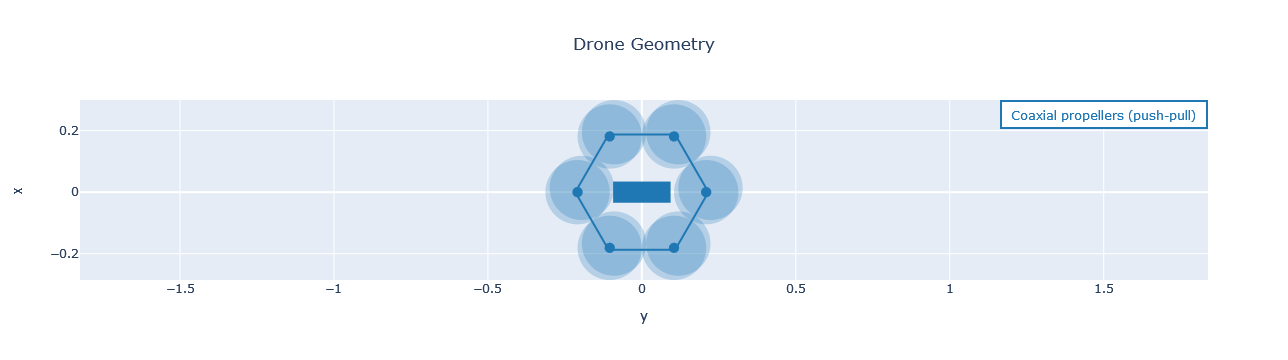

In [19]:
fig = multirotor_geometry_plot(MDO_OUTPUT_FILE, name="Drone MDO")
fig.show()

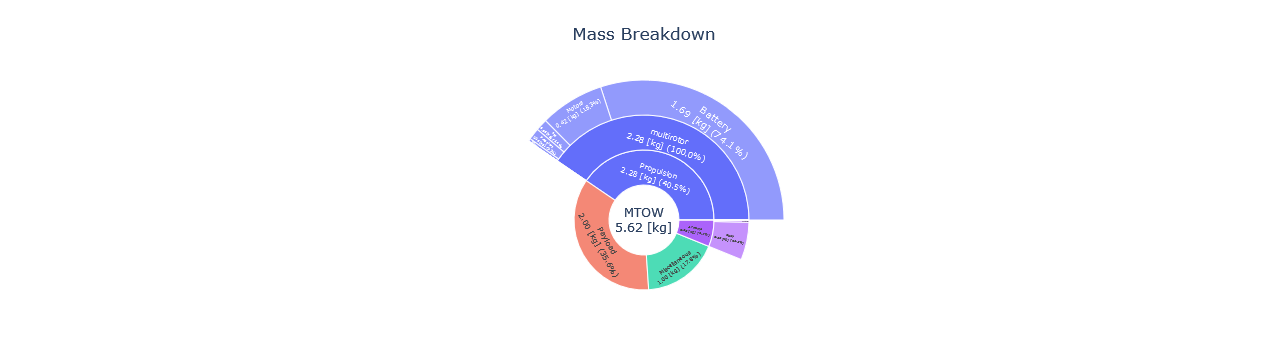

In [20]:
fig = mass_breakdown_sun_plot_drone(MDO_OUTPUT_FILE)
fig.show()

### 4.2 - LCA results

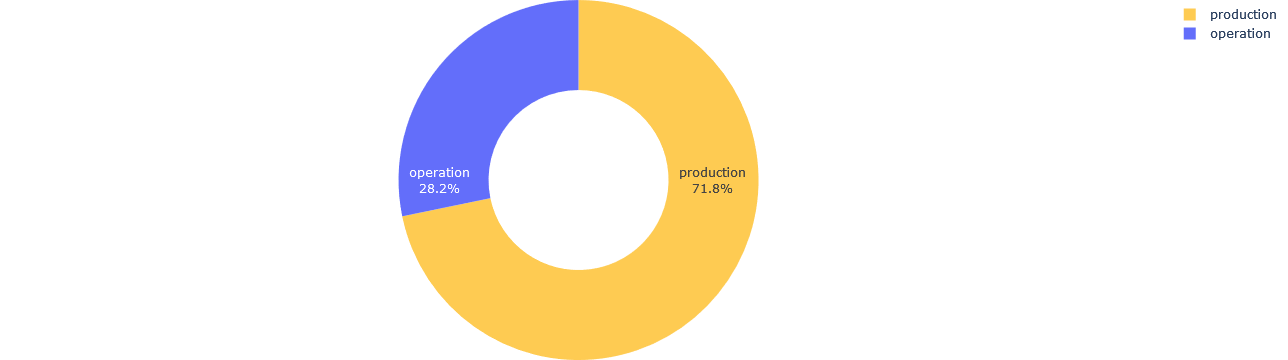

In [29]:
# Weighted single score
fig = lca_plot(OUTPUT_FILE, result_step = 'aggregation', filter_option = 'default', filter_level = 1)
fig.update_layout(
    title=None,
    margin=dict(l=10, r=10, t=0, b=0),
    width=350,
    height=280
)
colors = [px.colors.qualitative.Plotly[0], px.colors.qualitative.Plotly[9]]
fig.update_traces(marker=dict(colors=colors))
fig.show()
plotly.io.write_image(fig, 'output_file.pdf', format='pdf')

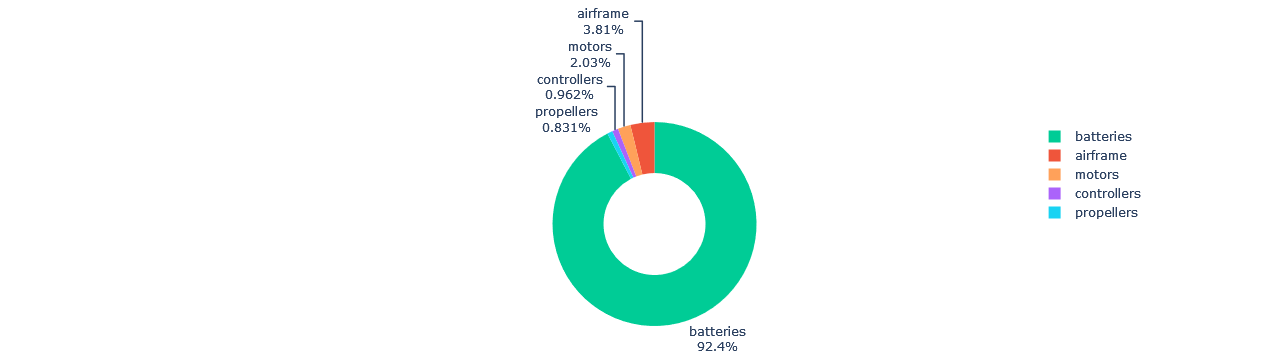

In [30]:
# Weighted single score
fig = lca_plot(OUTPUT_FILE, result_step = 'aggregation', filter_option = 'exact', filter_level = 2)
fig.update_layout(
    title=None,
    margin=dict(l=10, r=10, t=0, b=0),
    width=350,
    height=280
)
colors = [px.colors.qualitative.Plotly[i] for i in range(1,10)]
fig.update_traces(marker=dict(colors=colors))
fig.show()
plotly.io.write_image(fig, 'output_file.pdf', format='pdf')

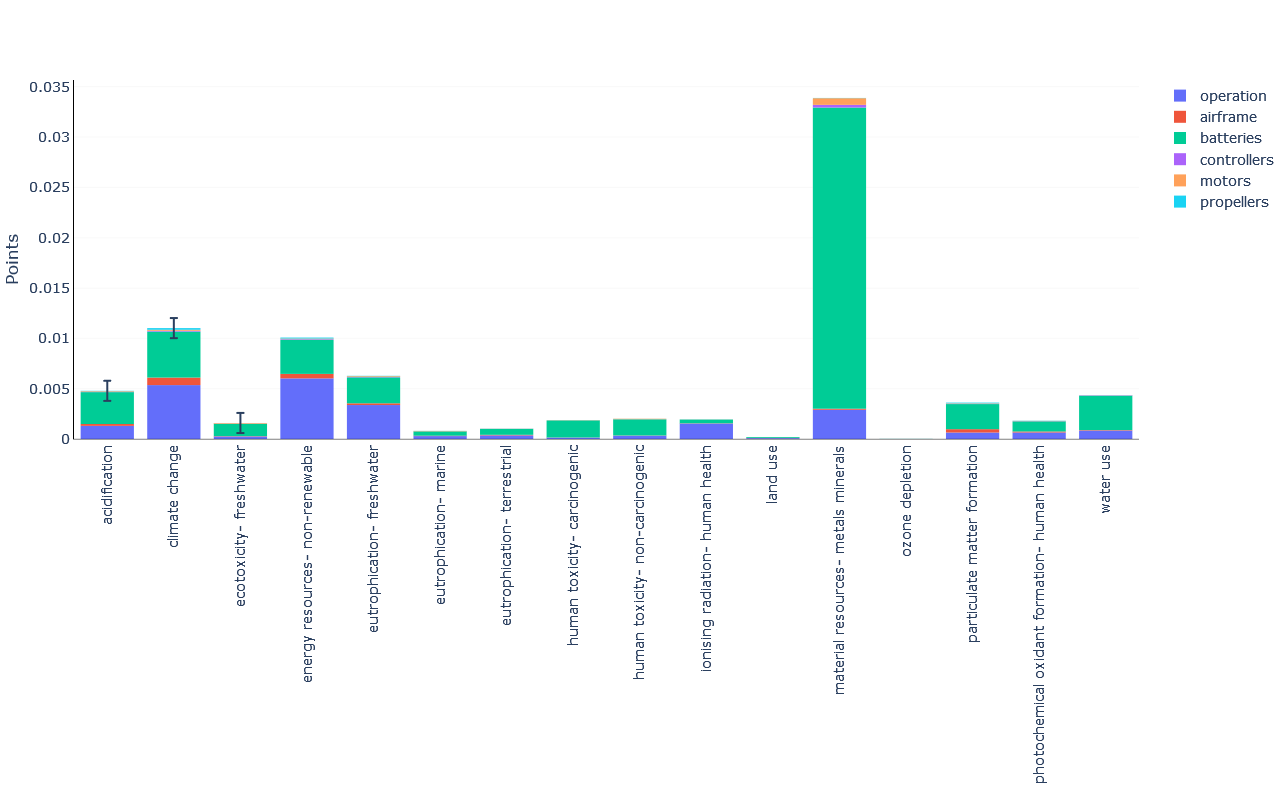

In [83]:
# Normalized and weighted scores for each impact category
fig = lca_plot(OUTPUT_FILE, result_step = 'weighting', filter_option = 'default', filter_level = 2, percent = False)
fig.update_layout(title=None, width=1000, height=800, paper_bgcolor='rgba(0,0,0,0)',  plot_bgcolor='rgba(0,0,0,0)', font=dict(size=14))
fig.update_xaxes(showline=True, linewidth=0.5, linecolor='black')
fig.update_yaxes(title='Points', showline=True, linewidth=1, linecolor='black', gridcolor='grey', gridwidth=0.05)
y_errors = [0.001, 0.001, 0.001]
for idx in range(len(fig.data)):
    fig.data[idx].x = [s.split("<br>", 2)[1] for s in fig.data[idx].x]
    fig.data[idx].marker.line.width = 0
fig.data[-1].error_y=dict(type="data", array=y_errors)
fig.show()
plotly.io.write_image(fig, 'output_file.pdf', format='pdf')

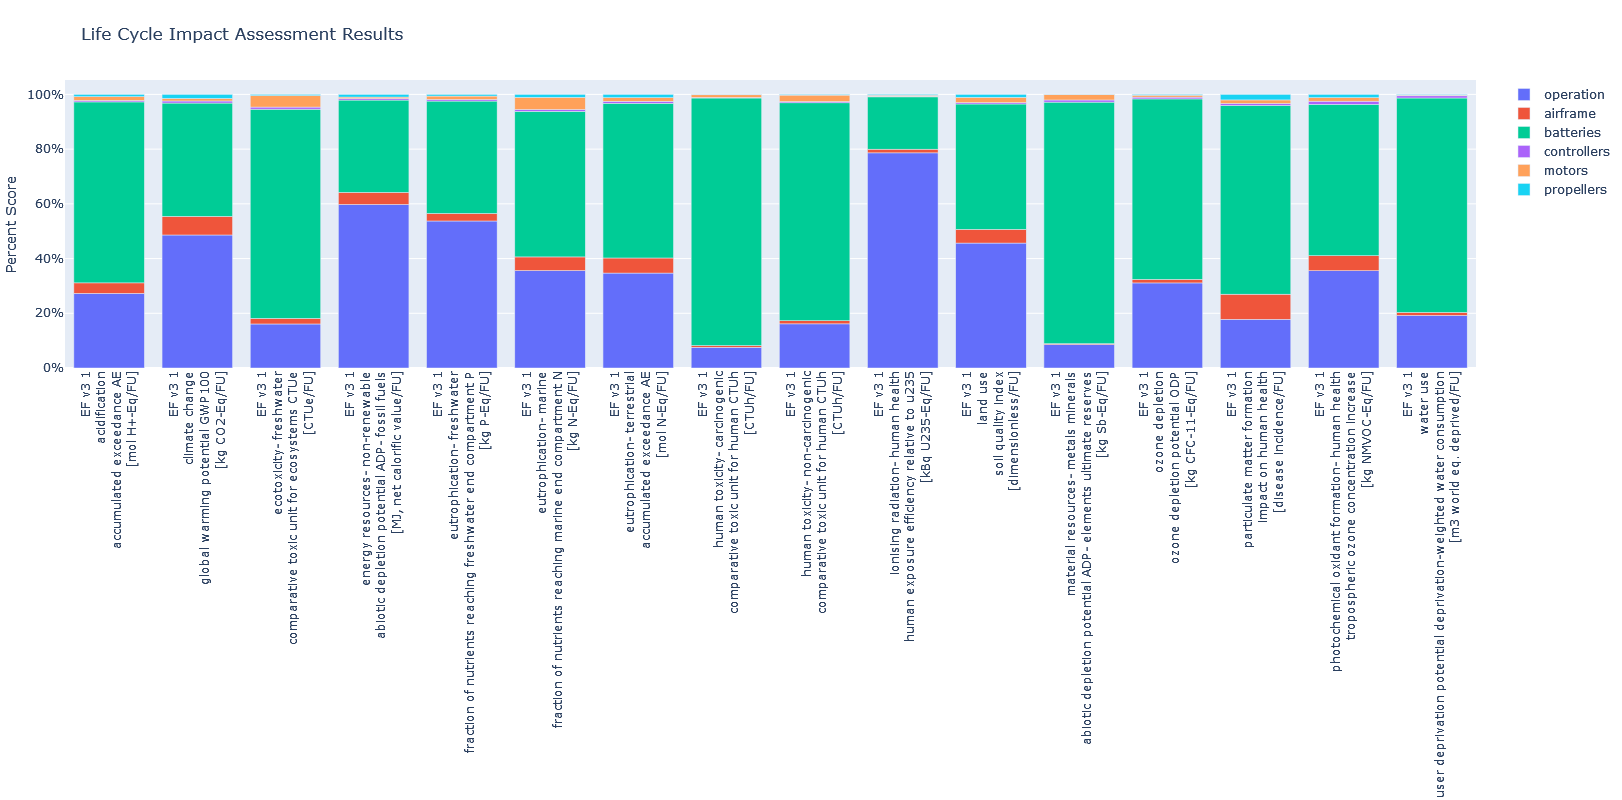

In [154]:
# Processes contributions in each impact category
fig = lca_plot(OUTPUT_FILE, result_step = 'characterization', filter_option = 'default', filter_level = 2, percent = True)
fig.update_layout(height=800)
fig.show()

#### **Splitting "operation" contribution into terms related to the components' masses and efficiencies.**

This analysis of the specific component contributions is only valid for cruise conditions.

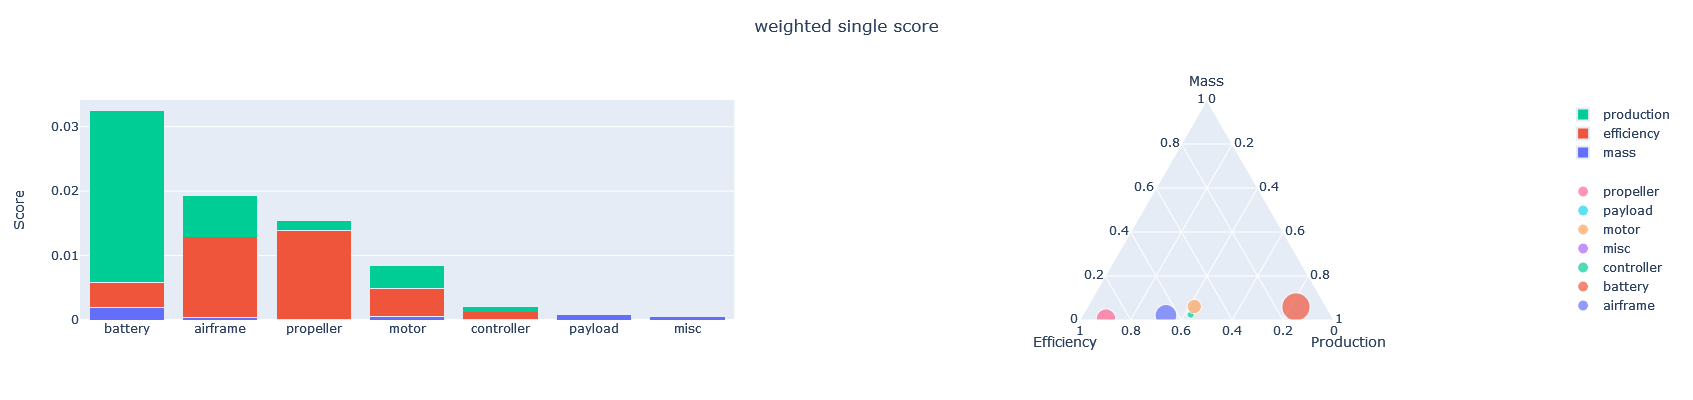

In [24]:
figs = lca_specific_contributions(OUTPUT_FILE, result_step = 'aggregation')
for fig in figs:
    fig.show()

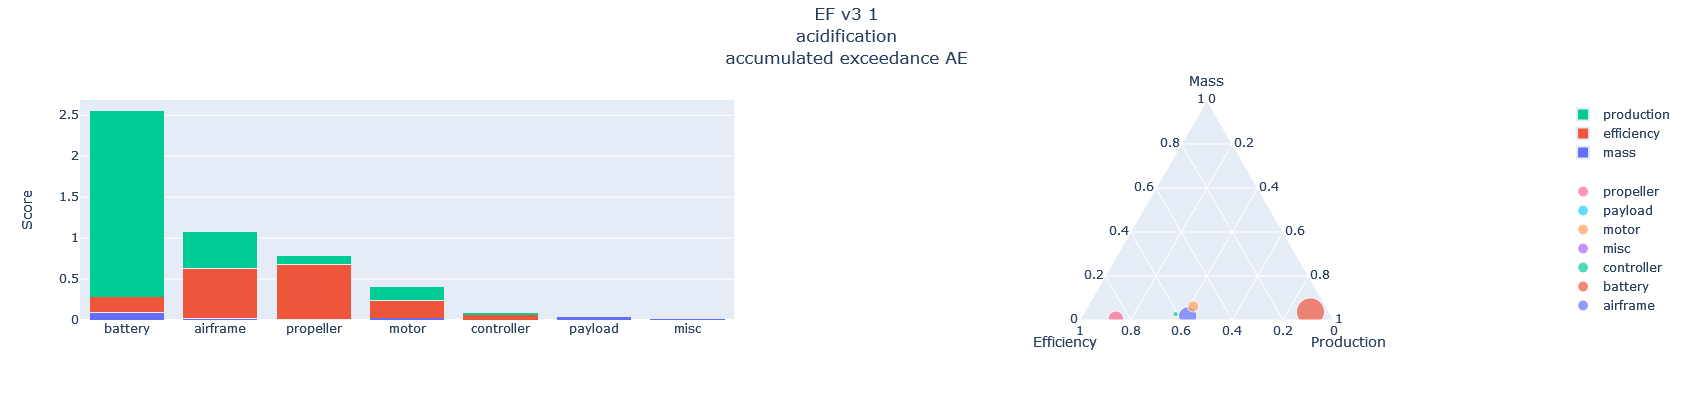

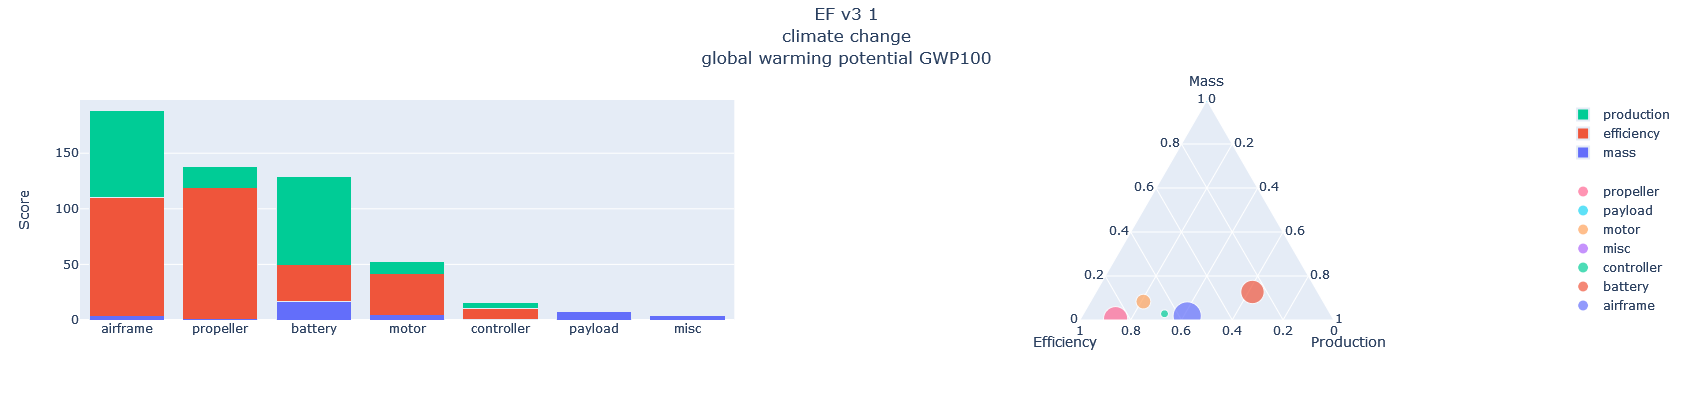

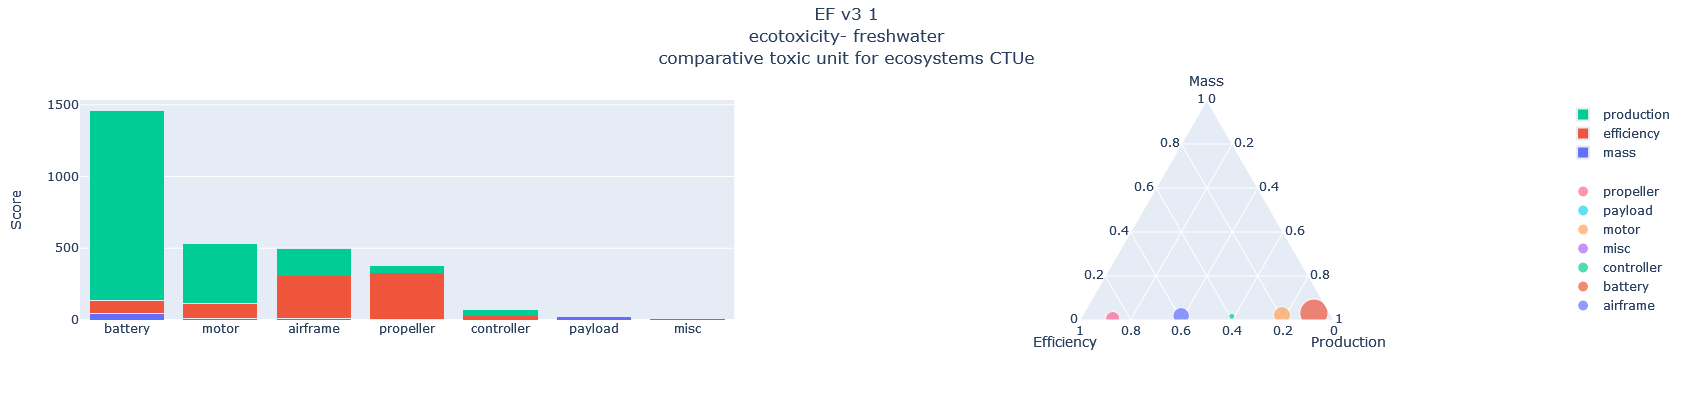

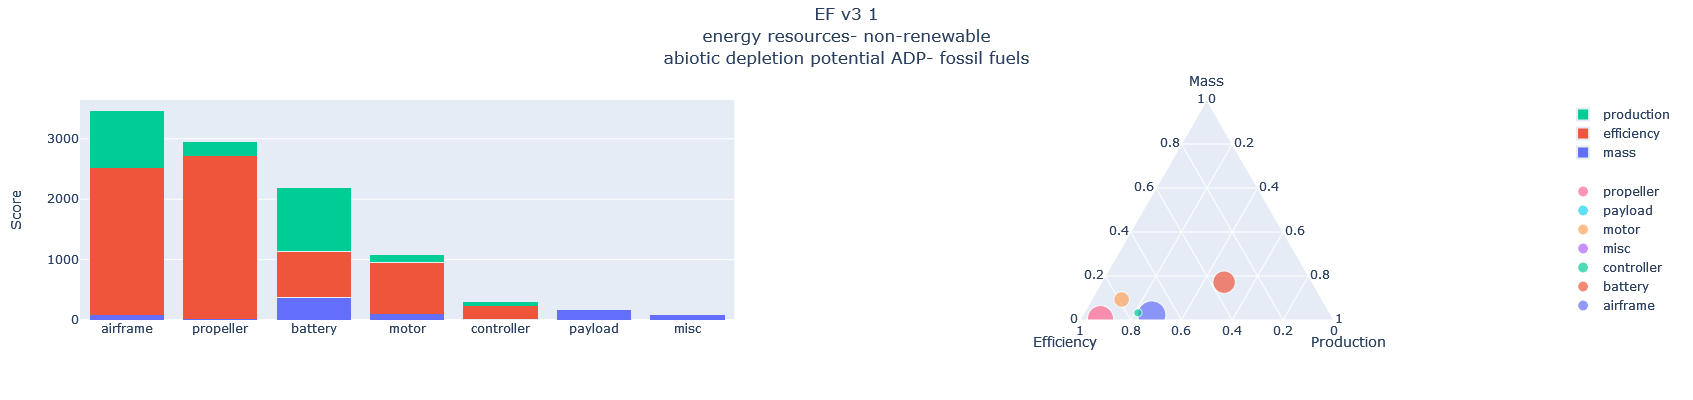

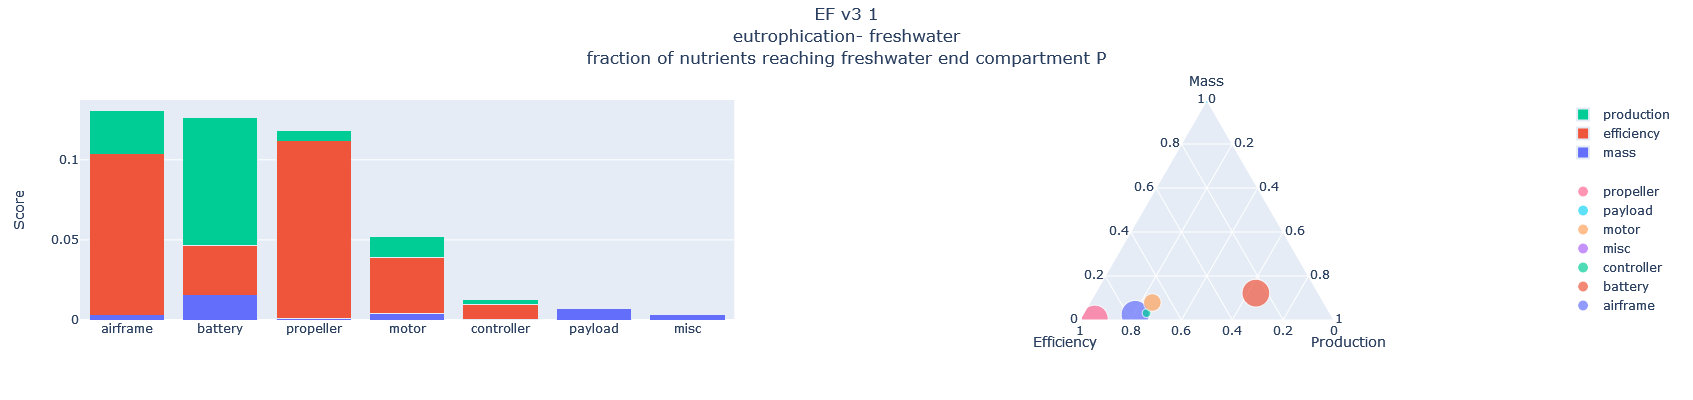

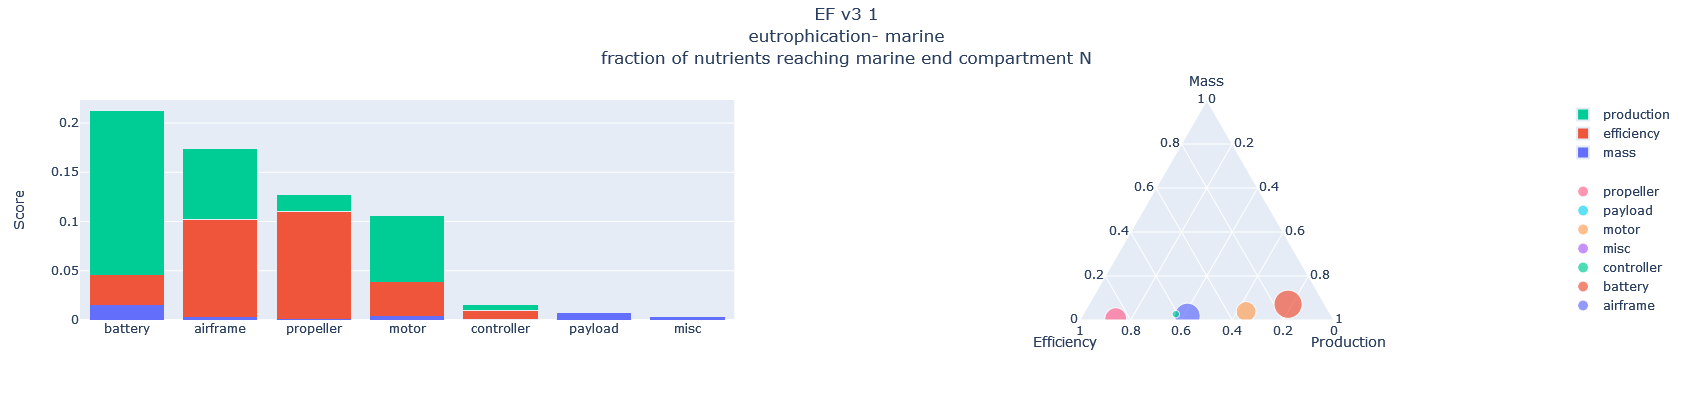

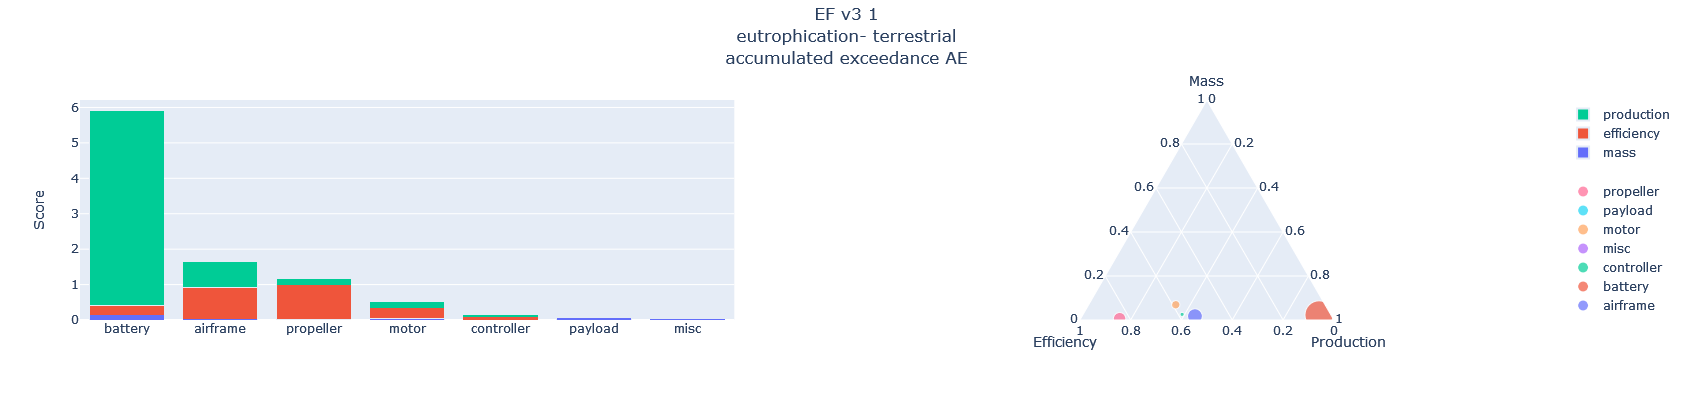

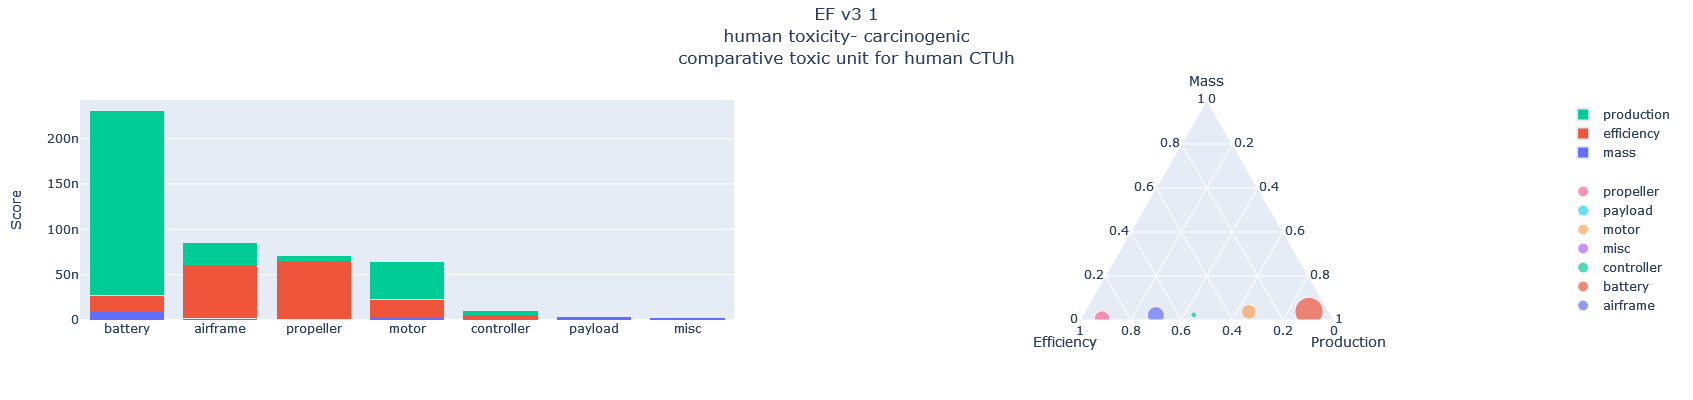

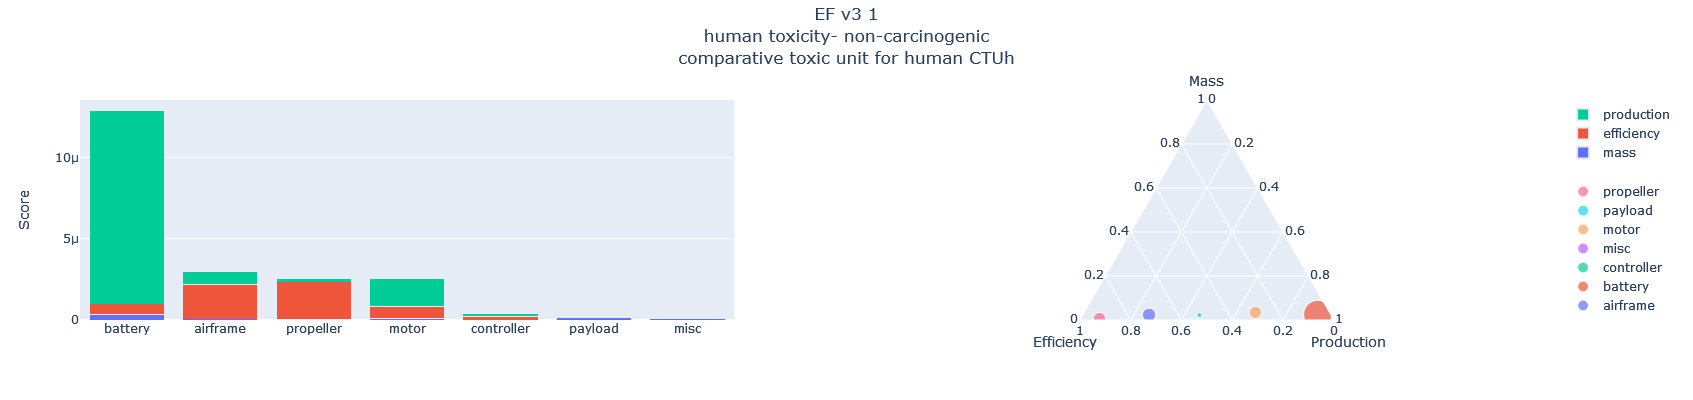

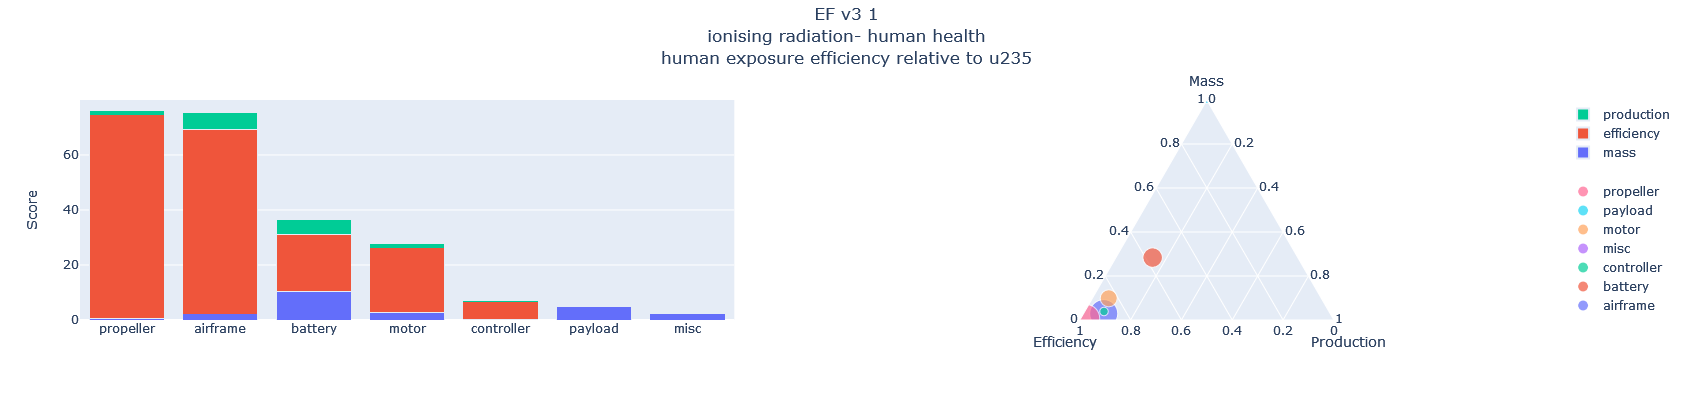

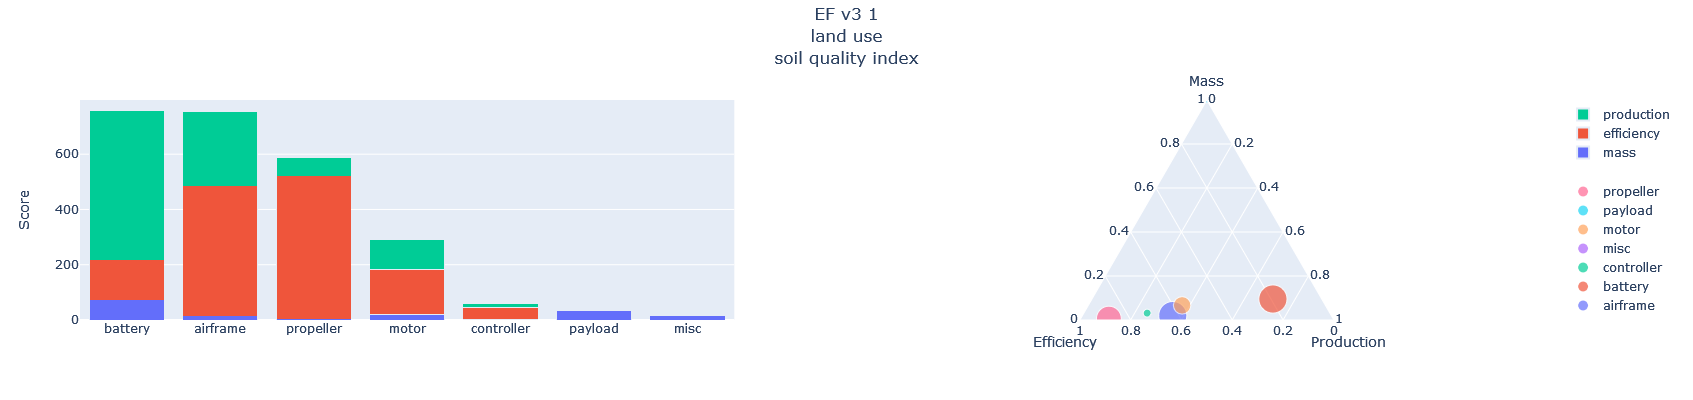

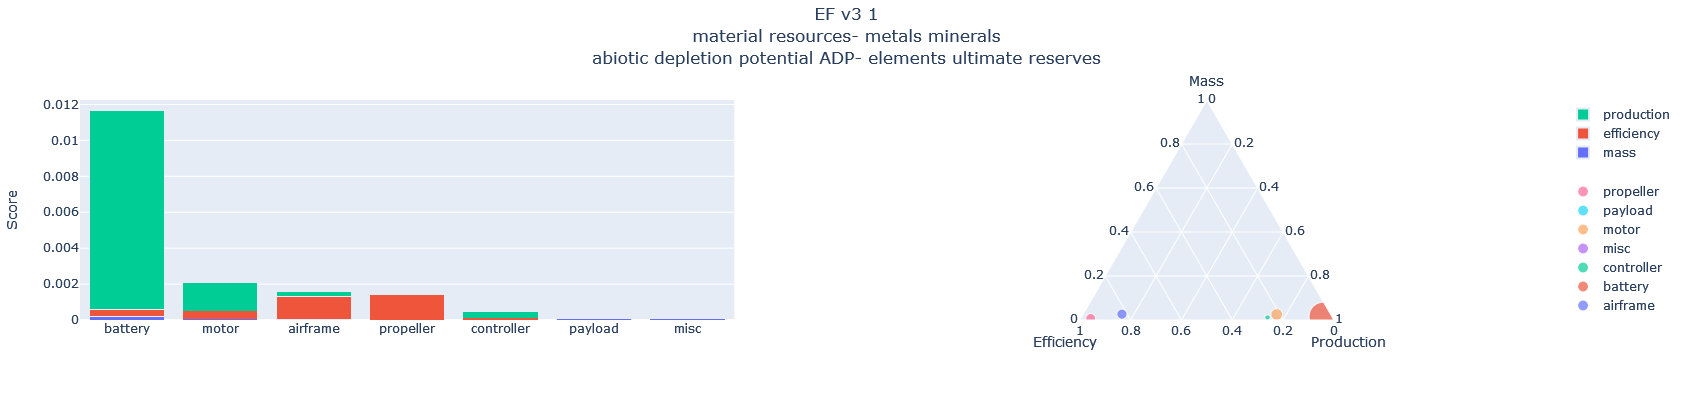

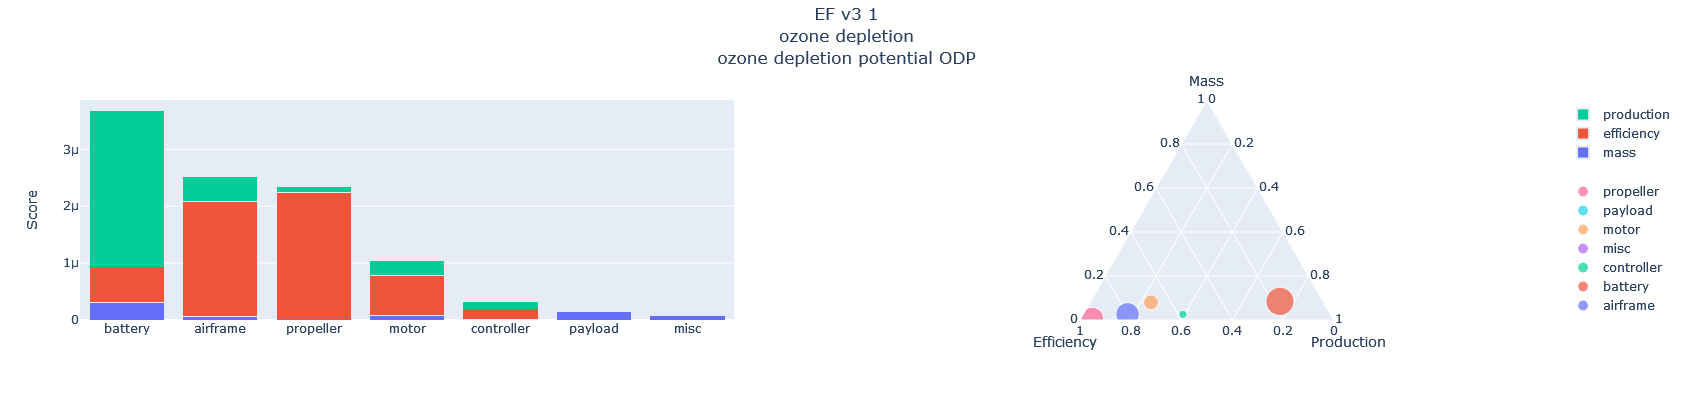

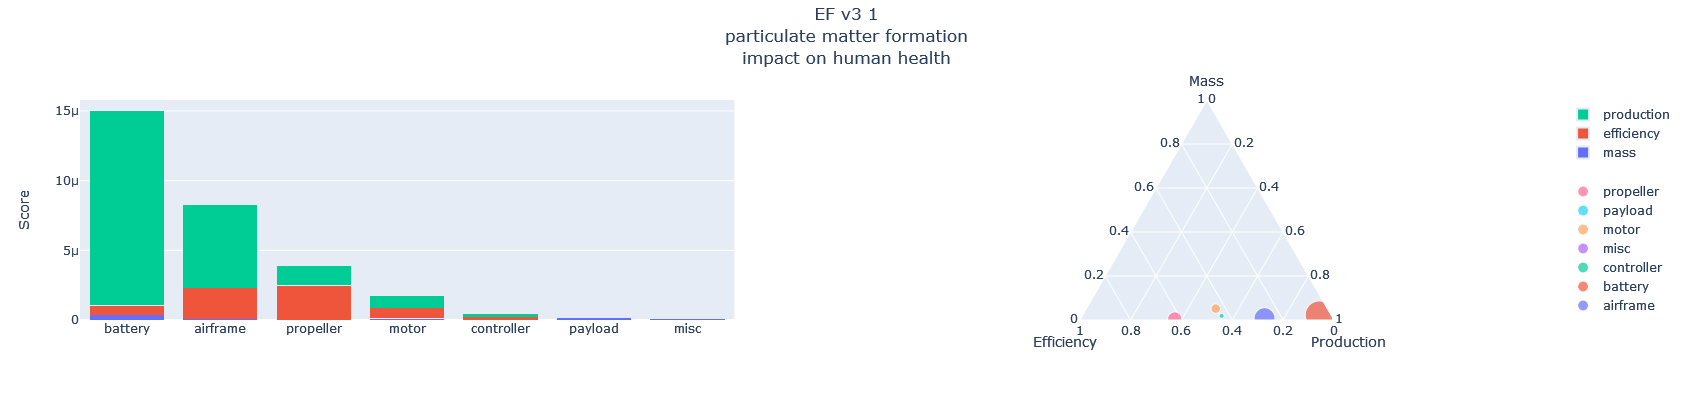

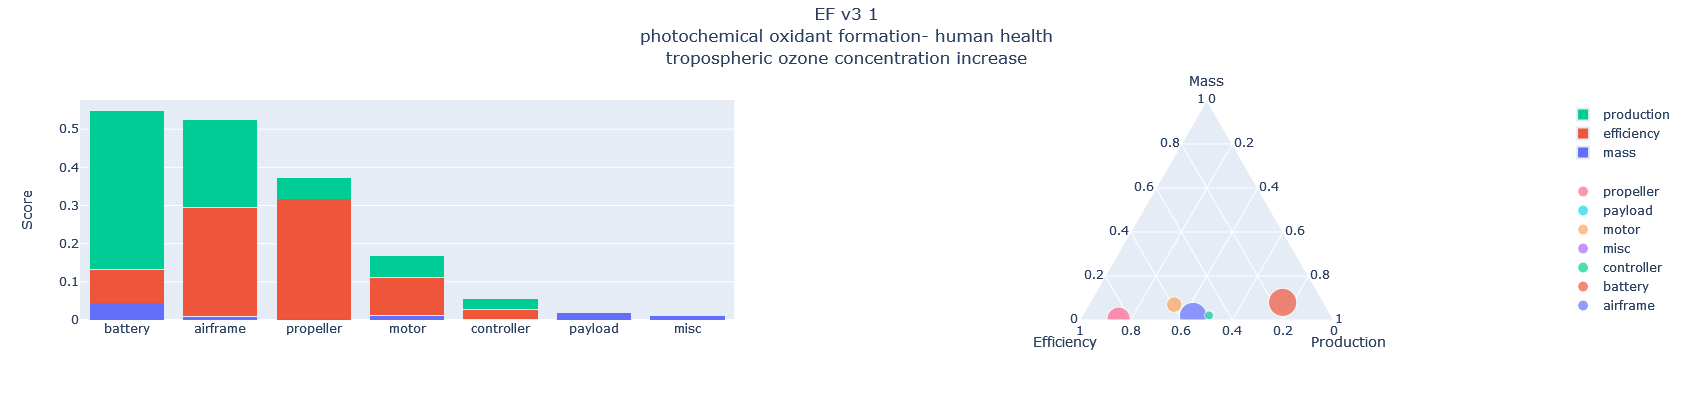

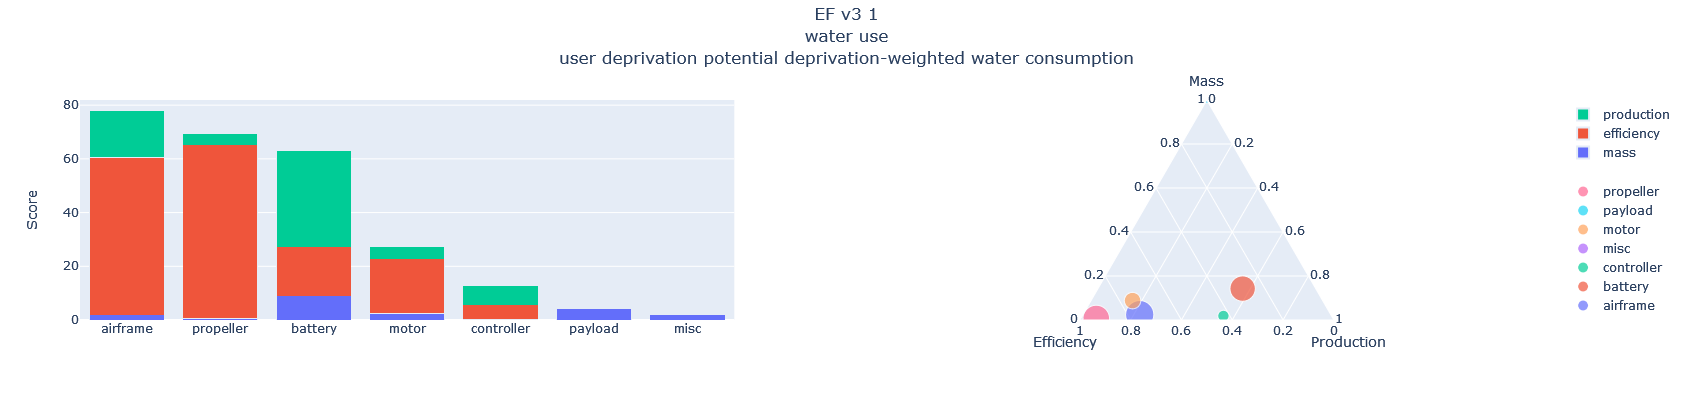

In [25]:
figs = lca_specific_contributions(OUTPUT_FILE, result_step = 'characterization')
for fig in figs:
    fig.show()

### 4.3 - Advanced LCA studies

In [26]:
# get all activities created in LCA module
activities = get_lca_activities()
activities

['anode_silicon_nanowire' (kilogram, CN, None),
 'controller' (kg, GLO, None),
 'motor' (kg, GLO, None),
 'airframe' (kg, GLO, None),
 'battery' (kg, GLO, None),
 'silicon_nanowire' (kg, GLO, None),
 'battery_cell_silicon_NMC811' (kilogram, CN, None),
 'production' (uav, GLO, None),
 'market_battery_cell_silicon_NMC811' (kilogram, GLO, None),
 'battery_recycling' (kg, GLO, None),
 'model per FU' (uav lifetime, GLO, None),
 'battery_production' (kilogram, GLO, None),
 'propeller' (kg, GLO, None),
 'operation' (kilowatt hour, GLO, None)]

In [10]:
# select top-level activity (model)
model = get_lca_main_activity()
model

'model per FU' (uav lifetime, GLO, None)

In [11]:
# get a particular activity
from fastuav.constants import LCA_USER_DB
test = lcalg.getActByCode(LCA_USER_DB, 'production')

In [12]:
# Another way of visualizing interactions
recursive_activities(model)

activity  \
model per FU                                                                             model per FU   
production                                                                                 production   
battery                                                                                       battery   
battery_production                                                                 battery_production   
market for battery cell, Li-ion, NMC811                       market for battery cell, Li-ion, NMC811   
market for battery cell, Li-ion, NMC111                       market for battery cell, Li-ion, NMC111   
market for battery cell, Li-ion, NCA                             market for battery cell, Li-ion, NCA   
market for battery cell, Li-ion, LFP                             market for battery cell, Li-ion, LFP   
market for battery, NiMH, rechargeable, prismatic   market for battery, NiMH, rechargeable, prismatic   
market_battery_cell_silicon_NMC811                                 market_battery_cell_silicon_NMC811   
battery cell production, Li-ion, NMC811 [RoW]           battery cell production, Li-ion, NMC811 [RoW]   
battery cell production, Li-ion, NMC811 [CN]             battery cell production, Li-ion, NMC811 [CN]   
market group for transport, freight train                   market group for transport, freight train   
market group for transport, freight, light comm...  market group for transport, freight, light com...   
market group for transport, freight, lorry, uns...  market group for transport, freight, lorry, un...   
market for transport, freight, sea, container ship  market for transport, freight, sea, container ...   
battery_cell_silicon_NMC811 [CN]                                     battery_cell_silicon_NMC811 [CN]   
market for aluminium collector foil, for Li-ion...  market for aluminium collector foil, for Li-io...   
market for aluminium, wrought alloy                               market for aluminium, wrought alloy   
market for anode, silicon coated graphite, for ...  market for anode, silicon coated graphite, for...   
market for battery separator                                             market for battery separator   
market for cathode, NMC811, for Li-ion battery ...  market for cathode, NMC811, for Li-ion battery...   
market for chemical factory, organics                           market for chemical factory, organics   
market for copper collector foil, for Li-ion ba...  market for copper collector foil, for Li-ion b...   
market for copper, anode                                                     market for copper, anode   
market group for electricity, medium voltage [CN]   market group for electricity, medium voltage [CN]   
market for electrolyte, for Li-ion battery                 market for electrolyte, for Li-ion battery   
market for extrusion, plastic film                                 market for extrusion, plastic film   
market for heat, district or industrial, natura...  market for heat, district or industrial, natur...   
market for polyethylene terephthalate, granulat...  market for polyethylene terephthalate, granula...   
market for polypropylene, granulate                               market for polypropylene, granulate   
market for sheet rolling, aluminium                               market for sheet rolling, aluminium   
market for sheet rolling, copper                                     market for sheet rolling, copper   
anode_silicon_nanowire [CN]                                               anode_silicon_nanowire [CN]   
market for carbon black                                                       market for carbon black   
market for carboxymethyl cellulose, powder                 market for carboxymethyl cellulose, powder   
market for chemical factory, organics                           market for chemical factory, organics   
market group for electricity, medium voltage [CN]   market group for electricity, medium voltage [CN]  

In [13]:
# list available parameters
list_lca_parameters()  # returns HTML table
# lcalg.params._variable_params()  # returns dictionnary of parameters

#### Monte Carlo

The vanilla Monte Carlo from brightway2 is used to calculate the uncertainty on each impact. Only uncertainties from EcoInvent datasets are taken into account. No uncertainty on characterization factors is provided by standard methods. Finally, values from algebraic parameters (e.g., components masses) are frozen.

In [147]:
from fastoad.io import VariableIO
from fastuav.constants import LCA_PARAM_KEY, LCA_DEFAULT_METHOD
import time

# Select model
model = get_lca_main_activity()  # top-level model

# Get parameters values from problem outputs
variables = VariableIO(OUTPUT_FILE).read()
param_names = [p for p in variables.names() if p.startswith(LCA_PARAM_KEY)]
parameters = {}
for p in param_names:
    parameters[p.replace(LCA_PARAM_KEY, "")] = variables[p].value[0]

# Run Monte Carlo
methods = [eval(m) for m in LCA_DEFAULT_METHOD]
res = lca_monte_carlo(
    model, # the model
    methods, # impacts to assess 

    # Number of Monte Carlo runs
    n_runs=1000, 
    
    # Whether uncertainty on characterization factors is taken into account or not
    cfs_uncertainty = False,

    # Parameters of the model
    **parameters
)

Freezing 'production' (uav, GLO, None) // batteries : mass_batteries*ceiling(n_cycles_uav/n_cycles_battery) => 11
Freezing 'production' (uav, GLO, None) // motors : mass_motors => 0
Freezing 'production' (uav, GLO, None) // airframe : mass_airframe => 0
Freezing 'production' (uav, GLO, None) // propellers : mass_propellers => 0
Freezing 'production' (uav, GLO, None) // controllers : mass_controllers => 0
Freezing 'operation' (kilowatt hour, GLO, None) // market group for electricity, low voltage : elec_switch_param_us => 0
Freezing 'operation' (kilowatt hour, GLO, None) // market group for electricity, low voltage : elec_switch_param_eu => 1
Freezing 'operation' (kilowatt hour, GLO, None) // market for electricity, low voltage : elec_switch_param_fr => 0
Freezing 'battery_recycling' (kg, GLO, None) // market for used Li-ion battery : battery_recycling_share => 0
Freezing 'model per FU' (uav lifetime, GLO, None) // operation : mission_energy*n_cycles_uav => 568
Freezing 'battery_product

INFO    : Created LCA object
INFO    : Seeded RNGs


Freezing 'battery_production' (kilogram, GLO, None) // market for battery, NiMH, rechargeable, prismatic : battery_type_nimh => 0
Freezing 'battery_production' (kilogram, GLO, None) // market_battery_cell_silicon_NMC811 : battery_type_si_nmc_811 => 0
### Running Multi-Impacts Monte Carlo (warning: uncertainty restricted to LCI) ###


INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method
INFO    : Switching LCIA method


In [149]:
res.describe()

EF v3.1                                    \
                    acidification                    climate change   
      accumulated exceedance (AE) global warming potential (GWP100)   
count                 1000.000000                       1000.000000   
mean                     5.024167                        471.132269   
std                      0.465675                         19.674496   
min                      1.120476                        277.771287   
25%                      4.720334                        458.611175   
50%                      4.969937                        470.320640   
75%                      5.286124                        483.101445   
max                      7.322400                        558.106502   

                                                    \
                           ecotoxicity: freshwater   
      comparative toxic unit for ecosystems (CTUe)   
count                                  1000.000000   
mean                                   3377.048494   
std                                   59148.209693   
min                                 -182438.339446   
25%                                  -36369.886377   
50%                                    2545.225835   
75%                                   45425.257347   
max                                  189234.910835   

                                                       \
                      energy resources: non-renewable   
      abiotic depletion potential (ADP): fossil fuels   
count                                     1000.000000   
mean                                      8880.170992   
std                                        562.985453   
min                                       5599.277229   
25%                                       8505.424602   
50%                                       8851.304286   
75%                                       9232.398759   
max                                      10947.057538   

                                                                     \
                                         eutrophication: freshwater   
      fraction of nutrients reaching freshwater end compartment (P)   
count                                        1000.000000              
mean                                            0.227090              
std                                             0.194394              
min                                            -0.134026              
25%                                             0.098918              
50%                                             0.181697              
75%                                             0.307134              
max                                             1.224515              

                                                                 \
                                         eutrophication: marine   
      fraction of nutrients reaching marine end compartment (N)   
count                                        1000.000000          
mean                                            0.686163          
std                                             0.069648          
min                                            -0.324055          
25%                                             0.646198          
50%                                             0.681891          
75%                                             0.724361          
max                                             1.020683          

                                                                           \
      eutrophication: terrestrial            human toxicity: carcinogenic   
      accumulated exceedance (AE) comparative toxic unit for human (CTUh)   
count                 1000.000000                             1000.000000   
mean                     6.970848                                0.000003   
std                      0.904797                                0.000021   
min                     -7.436497      

In [148]:
res.to_csv("./workdir/lca_monte_carlo.csv")

#### Simple DoE at LCA level

DoE on LCA parameters.

**Warning:** here no iteration on the design is made. DoE on the design plus the LCA can be made by hand or with a DoE on the whole FAST-UAV model. See further below.

In [ ]:
import lca_algebraic as lcalg
from fastoad.io import VariableIO
from fastuav.constants import LCA_PARAM_KEY, LCA_USER_DB

# Select activities/model to explore
model = lcalg.getActByCode(LCA_USER_DB, 'model per FU')
operation = lcalg.getActByCode(LCA_USER_DB, 'operation')
production = lcalg.getActByCode(LCA_USER_DB, 'production')

In [ ]:
# Get parameters values from problem outputs
variables = VariableIO(OUTPUT_FILE).read()
param_names = [p for p in variables.names() if p.startswith(LCA_PARAM_KEY)]
parameters = {}
for p in param_names:
    parameters[p.replace(LCA_PARAM_KEY, "")] = variables[p].value[0]
parameters

In [ ]:
# Set non-float parameters
parameters['elec_switch_param'] = "fr"
parameters['battery_type'] = "si_nmc_811"

# Modify parameter of interest
parameters['n_cycles_uav'] = list(np.geomspace(100.0, 5000, 10000))

# Choose lcia method
#method = [('ReCiPe 2016 v1.03, midpoint (E) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT')]
method = [('ReCiPe 2016 v1.03, endpoint (H) no LT', 'total: human health no LT', 'human health no LT')]

# activities and sub-activities to evaluate
activities = [model]  # [operation, production]

# Run LCA. The DoE is automatically performed.
data = {'n_cycles_uav': parameters['n_cycles_uav']}
for act in activities:
    res = lcalg.multiLCAAlgebric(
        act, # The model 
        method, # Impacts
        
        # Parameters of the model
        **parameters
    )
    data[act.as_dict()['name']] = res.iloc[:, 0].values
df = pd.DataFrame(data=data, index=parameters['n_cycles_uav'])
df['flight hours'] = df['n_cycles_uav'] * parameters['mission_duration']
df['functional_value'] = df['n_cycles_uav'] * parameters['mission_duration'] * parameters['mass_payload']
df.to_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_si_nmc_fr_endpoint.csv'))

#df['model per FU'] = df['model per FU'] / df['functional_value']
#df['operation'] = df['operation'] / df['functional_value']
#df['production'] = df['production'] / df['functional_value']

ax = df.plot(x='flight hours', y=['model per FU'], grid=True)
plt.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# dict for the dataframes and their names
dfs_NMC = {"NMC - FR": pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_nmc811_fr_endpoint.csv')),
           "NMC - EU": pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_nmc811_eu_endpoint.csv')),
           "NMC - US" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_nmc811_us_endpoint.csv')),
          }
dfs_LFP = {"LFP - FR" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_lfp_fr_endpoint.csv')),
           "LFP - EU" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_lfp_eu_endpoint.csv')),
           "LFP - US" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_lfp_us_endpoint.csv')),
          }
dfs_SI_NMC = {"SI NMC - FR" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_si_nmc_fr_endpoint.csv')),
              "SI NMC - EU" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_si_nmc_eu_endpoint.csv')),
              "SI NMC - US" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_si_nmc_us_endpoint.csv')),
          }

# plot the data
fig = go.Figure()

for i in dfs_NMC:
    fig = fig.add_trace(go.Scatter(x = dfs_NMC[i]["flight hours"],
                                   y = dfs_NMC[i]["model per FU"], 
                                   name = i,
                                   line = dict(width=2)))
for i in dfs_LFP:
    fig = fig.add_trace(go.Scatter(x = dfs_LFP[i]["flight hours"],
                                   y = dfs_LFP[i]["model per FU"], 
                                   name = i,
                                   line = dict(width=2, dash='dash')))
    
for i in dfs_SI_NMC:
    fig = fig.add_trace(go.Scatter(x = dfs_SI_NMC[i]["flight hours"],
                                   y = dfs_SI_NMC[i]["model per FU"], 
                                   name = i,
                                   line = dict(width=2, dash='dot')))

fig.update_layout(title='Human Health', #Global Warming Potential',
                   xaxis_title='Lifetime (hours)',
                   yaxis_title='DALY', #kgCO2eq/FU',
                  width=900,
                  height=500,)
fig.show()

### Draft

In [ ]:
# Set non-float parameters
parameters['elec_switch_param'] = "eu"

# Modify parameter of interest
parameters['n_cycles'] = list(np.geomspace(1.0, 5000, 10000))

# Choose lcia method
method = [('ReCiPe 2016 v1.03, midpoint (E) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT')]
method = [('ReCiPe 2016 v1.03, midpoint (E) no LT', 'acidification: terrestrial no LT', 'terrestrial acidification potential (TAP) no LT')]

# activities and sub-activities to evaluate
activities = [operation, production]

# Have a look to NiMH batteries
# Run LCA. The DoE is automatically performed.
data = {'n_cycles': parameters['n_cycles']}
parameters['battery_type'] = "nmc_811"
parameters['n_cycles_battery'] = 1000
for act in activities:
    res = lcalg.multiLCAAlgebric(
        act, # The model 
        method, # Impacts
        
        # Parameters of the model
        **parameters
    )
    data[act.as_dict()['name']] = res.iloc[:, 0].values
df1 = pd.DataFrame(data=data, index=parameters['n_cycles'])
df1['flight hours'] = df1['n_cycles'] * parameters['mission_duration']
df1['operation'] = 0.6 * df1['operation']
df1['model'] = df1['operation'] + df1['production']
df1['functional_value'] = df1['n_cycles'] * parameters['mission_duration'] * parameters['mass_payload']

# Do the same with Li-ion batteries
data = {'n_cycles': parameters['n_cycles']}
parameters['battery_type'] = "lfp"
parameters['n_cycles_battery'] = 3000
for act in activities:
    res = lcalg.multiLCAAlgebric(
        act, # The model 
        method, # Impacts
        
        # Parameters of the model
        **parameters
    )
    data[act.as_dict()['name']] = res.iloc[:, 0].values
df2 = pd.DataFrame(data=data, index=parameters['n_cycles'])
df2['flight hours'] = df2['n_cycles'] * parameters['mission_duration']
df2['model'] = df2['operation'] + df2['production']
df2['functional_value'] = df2['n_cycles'] * parameters['mission_duration'] * parameters['mass_payload']

#df['model'] = df['model'] / df['functional_value']
#df['operation'] = df['operation'] / df['functional_value']
#df['production'] = df['production'] / df['functional_value']

In [ ]:
#df.plot(x='flight hours', y=['model', 'operation', 'production'], grid=True)

ax = df1.plot(x='flight hours', y=['production', 'operation', 'model'])
df2.plot(ax=ax, x='flight hours', y=['production', 'operation', 'model'], style=['--', '--', '--'], grid=True)
plt.show()

#### Monte Carlo

In [ ]:
from fastoad.io import VariableIO
from fastuav.constants import PARAM_VARIABLE_KEY

# Select model
model = get_lca_main_activity()  # top-level model

# Get parameters values from problem outputs
variables = VariableIO(DJI_M600_OUTPUT_FILE).read()
param_names = [p for p in variables.names() if p.startswith(PARAM_VARIABLE_KEY)]
parameters = {}
for p in param_names:
    parameters[p.replace(PARAM_VARIABLE_KEY, "")] = variables[p].value[0]

# Choose method
method = ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT')

# Mixed DoE + Monte Carlo
scores = {}
#for elec in list(["eu", "us", "fr"]):  # DoE
#    parameters["elec_switch_param"] = elec  # Set DoE parameter

parameters["elec_switch_param"] = "fr"
for bat in list(["li_ion", "nimh"]):
    parameters["battery_type"] = bat
    if bat == "li_ion":
        parameters["n_cycles_battery"] = 800
    else:
        parameters["n_cycles_battery"] = 1200
    
    # Run Monte Carlo
    res = LCAMonteCarlo(
        model, # the model
        method, # impacts to assess 

        # Number of Monte Carlo runs
        n_runs=1000, 

        # Parameters of the model
        **parameters
    )
    scores[bat] = res[0]  # score distribution

In [ ]:
# plot distributions
for k, v in scores.items():
    plt.hist(v, bins=50);    
plt.show()